<a href="https://colab.research.google.com/github/nithindsouza/AutoEncoder_Nasdaq100/blob/main/AutoEncoder_Nasdaq100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#required libraries
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np

In [2]:
# Stocks symbols
df = pd.read_csv('/content/sample_data/nasdaq100_stocks.csv', header=None)
stocks_symbols = np.squeeze(df, axis=1).tolist()

In [3]:
# Index symbol
index_symbol = '^NDX'

In [ ]:
# Download index data
data = pd.DataFrame()    # Empty dataframe
data[index_symbol] = pd.read_csv("/content/sample_data/^NDX.csv")['Adj Close']
data.head(10)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [2]:
# Load data
stocks_data = pd.read_pickle('/content/sample_data/nasdaq100_6y .pkl')
index_data = pd.read_pickle('/content/sample_data/nasdaq100_index_6y .pkl')
assets_names = stocks_data.columns.values

data_assets = stocks_data
data_index = index_data

print("Stocks data (time series) shape: {shape}".format(shape=stocks_data.shape))
print("Index data (time series) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Stocks data (time series) shape: (1510, 98)
Index data (time series) shape: (1510,)


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AAL,AMGN,ADI,AAPL,AMAT,ASML,ADSK,ADP,BIDU,BIIB,BMRN,BKNG,AVGO,CDNS,CELG,CERN,CHTR,CHKP,CTAS,CSCO,CTXS,CTSH,CMCSA,COST,CSX,CTRP,DLTR,EBAY,EA,EXPE,FB,FAST,...,MAR,MELI,MCHP,MU,MSFT,MDLZ,MNST,MYL,NTAP,NFLX,NVDA,NXPI,ORLY,PCAR,PAYX,PEP,QCOM,REGN,ROST,SIRI,SWKS,SBUX,SYMC,SNPS,TMUS,TTWO,TSLA,TXN,ULTA,UAL,VRSN,VRSK,VRTX,WBA,WDAY,WDC,WLTW,WYNN,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,10.310681,38.340000,2.53,100.050003,28.400000,361.987000,359.288177,257.309998,13.317790,76.250526,37.301983,69.319641,10.500547,62.326241,36.939999,43.842960,104.120003,150.000000,51.919998,638.400024,28.453209,14.00,40.549999,40.124756,78.099998,49.240002,39.041798,16.701340,53.728039,37.100945,17.213152,87.877045,17.742678,11.580,39.900002,22.383545,14.55,59.622776,28.000000,20.283932,...,35.534439,80.506470,28.502575,6.63,23.584339,23.695293,18.076666,27.700001,30.435581,13.144286,11.810995,27.520674,89.870003,37.212318,26.137842,57.363400,52.772877,181.199997,24.859806,2.955661,20.185839,23.936625,13.826466,32.279999,15.774906,11.48,35.360001,27.187948,101.529999,24.190001,39.849998,52.786572,43.650002,33.046200,52.910000,36.001884,83.655464,99.407043,21.625166,31.863600
2013-01-03,10.367179,37.750000,2.49,98.480003,29.170000,362.197205,359.496826,258.480011,13.012948,75.771561,36.700058,68.444672,10.473944,61.019608,36.369999,44.015667,104.980003,147.860001,52.169998,648.729980,28.601856,13.63,40.834999,40.005058,77.980003,47.180000,39.218452,16.791662,51.915298,36.720875,17.021000,88.777901,17.909809,11.675,39.480000,21.907387,14.74,59.226849,27.770000,20.347540,...,35.818428,80.956558,28.206999,6.90,23.268398,23.668636,17.403334,27.620001,30.320230,13.798572,11.820279,27.382231,90.209999,37.044407,26.178877,57.388214,52.528370,180.710007,26.841654,3.014383,20.036661,24.097651,13.762650,31.900000,15.661067,11.88,34.770000,26.834530,101.989998,24.930000,40.029999,53.394344,45.150002,32.811760,52.299999,35.653797,84.510071,100.476288,21.561975,31.803463
2013-01-04,10.517838,38.130001,2.59,97.620003,29.309999,369.354340,366.600616,259.149994,14.032263,76.105133,36.047298,66.538162,10.473944,60.394299,36.360001,44.406113,104.650002,145.929993,52.540001,648.409973,28.418230,13.43,41.044998,40.433987,77.599998,46.840000,39.599670,16.816288,52.451233,36.633167,17.012066,88.492058,18.420019,11.795,39.619999,22.045223,14.88,60.763378,28.760000,20.372988,...,35.937515,81.005486,28.046535,6.96,22.832916,23.757483,17.296667,28.200001,30.240374,13.711429,12.210264,27.036121,91.650002,37.420204,26.400450,57.470959,51.754105,181.070007,26.462637,3.033956,19.533176,24.236917,13.911550,31.650000,15.823694,12.20,34.400002,26.775625,97.849998,25.850000,40.040001,53.304672,45.849998,32.282124,52.189999,35.537758,84.485657,101.688660,21.640961,31.356745
2013-01-07,10.527254,37.939999,2.67,97.309998,28.940001,367.742737,365.001007,268.459991,14.137052,75.720253,36.157497,66.146751,10.349777,59.414318,36.090000,44.233406,102.290001,146.419998,52.139999,657.380005,28.260838,13.41,42.865002,41.406555,77.400002,47.200001,39.515987,16.660280,53.720150,36.793961,16.936100,87.807762,17.997778,11.850,39.959999,22.350130,14.45,60.716251,29.420000,20.279684,...,35.735977,80.839165,28.012754,7.18,22.790224,23.686405,16.686666,27.910000,29.495008,14.171429,11.857423,26.838343,90.050003,37.012424,26.277353,57.462681,52.169762,182.529999,26.289110,3.014383,19.822216,24.249977,13.932821,31.420000,15.547228,12.16,34.340000,26.859772,96.320000,25.670000,40.060001,53.065544,47.290001,33.020153,52.169998,35.554348,84.241486,102.033867,21.411921,31.227875
2013-01-08,10.348347,38.139999,2.67,97.489998,28.250000,367.017029,364.280701,266.380005,14.441895,75.395241,35.784473,66.324783,10.207882,58.929001,36.299999,44.488701,101.089996,144.389999,51.840000,657.419983,28.068472,13.68,45.705002,40.862915,77.199997,48.220001,39.627563,16.676702,53.956600,36.301826,17.052286,87.643173,18.04175

In [3]:
# Split data
n_train = int(data_assets.shape[0]*0.8)

# Stocks data
X_train = data_assets.values[:n_train, :]
X_test = data_assets.values[n_train:, :]

# Index data
index_train = data_index[:n_train]
index_test = data_index[n_train:]

In [4]:
# Normalize data
scaler = MinMaxScaler([0, 1])
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
index_test = scaler_index.fit_transform(index_test[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [5]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 50
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(8, input_shape=(n_inputs,), activation='relu')(input)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(n_inputs, activation='sigmoid')(decoded)

In [6]:
# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

# Fit the model
history = model.fit(X_train, X_train,epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 792       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 98)                882       
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1208/1208 [==============================] - 5s 2ms/step - loss: 0.0376
Epoch 2/50
1208/1208 [==================

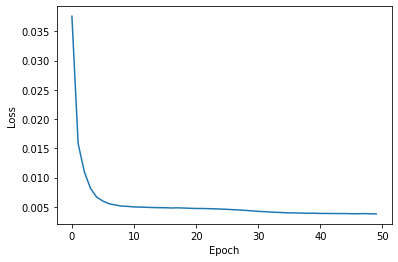

In [7]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
# Evaluate model
score_train = model.evaluate(X_train, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

302/302 [==============================] - 0s 2ms/step - loss: 0.0924
Training MSE: 0.00376039
Testing MSE: 0.09243292


In [9]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

Training MSE: 0.00376039
Testing MSE: 0.09243291


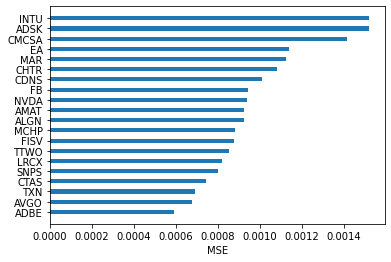

In [10]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()

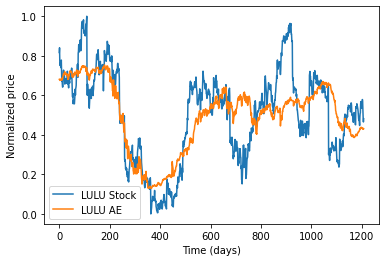

In [11]:
# Plot stock
i=-1
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [12]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

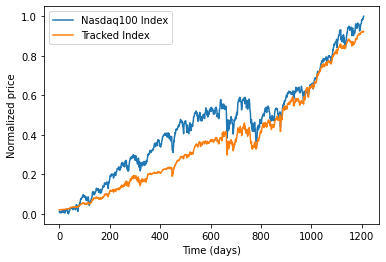

In [13]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [14]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.97597157


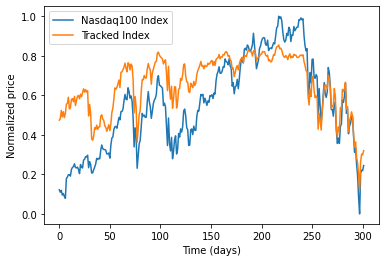

In [15]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [16]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.81266621


In [ ]:
# Generate corrupted series by adding noise with normal distribution
noise_factor = 0.05
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
# Clip corrupter data
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

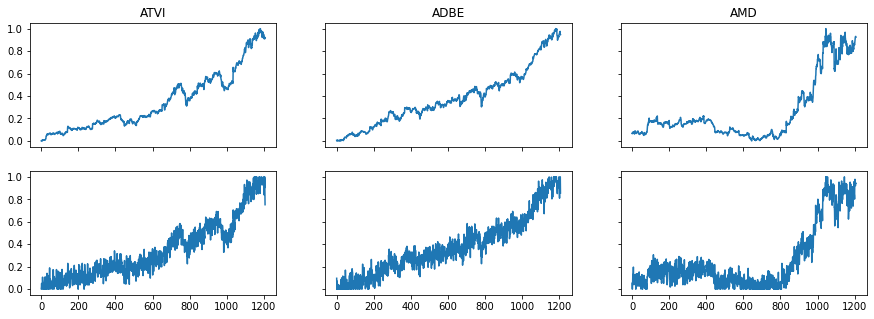

In [20]:
# Visualize corrupted data
f, axarr = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,5))

# Asset 1
axarr[0,0].plot(X_train[:, 0])
axarr[0,0].set_title(assets_names[0])
axarr[1,0].plot(X_train_noisy[:, 0])

# Asset 2
axarr[0,1].plot(X_train[:, 1])
axarr[0,1].set_title(assets_names[1])
axarr[1,1].plot(X_train_noisy[:, 1])

# Asset 3
axarr[0,2].plot(X_train[:, 2])
axarr[0,2].set_title(assets_names[2])
axarr[1,2].plot(X_train_noisy[:, 2])

plt.show()

In [21]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 50
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(8, input_shape=(n_inputs,), activation='relu')(input)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(n_inputs, activation='sigmoid')(decoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

# Fit the model
history = model.fit(X_train_noisy, X_train,epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 792       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 98)                882       
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1208/1208 [==============================] - 3s 2ms/step - loss: 0.0459
Epoch 2/50
1208/1208 [==================

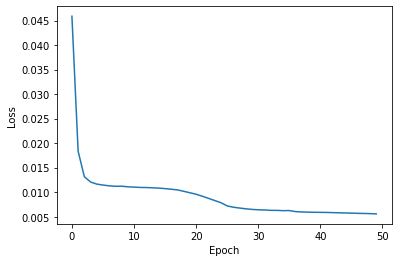

In [22]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [23]:
# Evaluate model
score_train = model.evaluate(X_train_noisy, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test_noisy, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

302/302 [==============================] - 0s 2ms/step - loss: 0.0770
Training MSE: 0.00538661
Testing MSE: 0.07698261


In [24]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train_noisy)
X_test_pred = model.predict(X_test_noisy)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00538661
Testing MSE: 0.07698260


In [26]:
# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

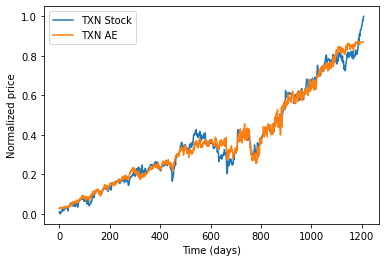

In [27]:
# Plot
i = 0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

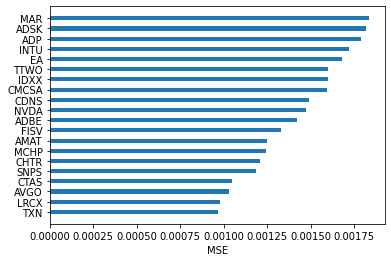

In [28]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
#plt.xticks(rotation=25)
plt.show()

In [29]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

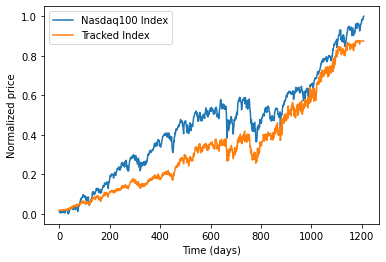

In [30]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [31]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.97122170


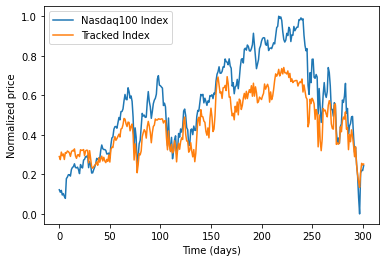

In [32]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [33]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.95423372
